In [23]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [24]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

# ../../Data/Processed data\250 shojja.xlsx
# ../../Data/Processed data\31 shojja.xlsx
# ../../Data/Processed data\ad-din.xlsx
# ../../Data/Processed data\aichi.xlsx
# ../../Data/Processed data\Al manar.xlsx
# ../../Data/Processed data\Anowar khan.xlsx
# ../../Data/Processed data\azgol ali.xlsx
# ../../Data/Processed data\Delta medical.xlsx
# ../../Data/Processed data\dmd central.xlsx
# ../../Data/Processed data\h&h.xlsx
# ../../Data/Processed data\hfrc.xlsx
# ../../Data/Processed data\ibn sina.xlsx
# ../../Data/Processed data\islami bank.xlsx
# ../../Data/Processed data\lstm_dmc.xlsx
# ../../Data/Processed data\Medical college for women.xlsx
# ../../Data/Processed data\Metropoliton medical.xlsx
# ../../Data/Processed data\police hospital.xlsx
# ../../Data/Processed data\popular medical.xlsx
# ../../Data/Processed data\shomorita.xlsx
# ../../Data/Processed data\Square.xlsx
# ../../Data/Processed data\ssmc.xlsx
# ../../Data/Processed data\united hospital.xlsx
# ../../Data/Processed data\universal.xlsx
# ../../Data/Processed data\Uttara adhunik.xlsx

# df = read_excel('../../Data/Processed data/31 shojja.xlsx')
# df = read_excel('../../Data/Processed data/250 shojja.xlsx')
# df = read_excel('../../Data/Processed data/ad-din.xlsx')
# df = read_excel('../../Data/Processed data/aichi.xlsx')
# df = read_excel('../../Data/Processed data/Al manar.xlsx')
# df = read_excel('../../Data/Processed data/Anowar khan.xlsx')
# df = read_excel('../../Data/Processed data/azgol ali.xlsx')
# df = read_excel('../../Data/Processed data/Delta medical.xlsx')
# df = read_excel('../../Data/Processed data/dmd central.xlsx')
# df = read_excel('../../Data/Processed data/h&h.xlsx')
# df = read_excel('../../Data/Processed data/hfrc.xlsx')
# df = read_excel('../../Data/Processed data/ibn sina.xlsx')
# df = read_excel('../../Data/Processed data/islami bank.xlsx')
df = read_excel('../../Data/Processed data/lstm_dmc.xlsx')
# df = read_excel('../../Data/Processed data/Medical college for women.xlsx')
# df = read_excel('../../Data/Processed data/Metropoliton medical.xlsx')
# df = read_excel('../../Data/Processed data/police hospital.xlsx')
# df = read_excel('../../Data/Processed data/popular medical.xlsx')
# df = read_excel('../../Data/Processed data/shomorita.xlsx')
# df = read_excel('../../Data/Processed data/Square.xlsx')
# df = read_excel('../../Data/Processed data/ssmc.xlsx')
# df = read_excel('../../Data/Processed data/united hospital.xlsx')
# df = read_excel('../../Data/Processed data/universal.xlsx')
# df = read_excel('../../Data/Processed data/Uttara adhunik.xlsx')
# df = read_excel('../../Data/Processed data/Sajeda hospital.xlsx')
# df = read_excel('../../Data/Processed data/Dhaka central.xlsx')

In [25]:
# convert Date field to float
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype(float)
#sort by date
df = df.sort_values(by='Date')
# for rows where df['Affected'] is null or non-numeric, replace with 0
df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
df.reset_index(drop=True, inplace=True)

In [26]:
df.shape

(698, 2)

In [27]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 8
input_size = 14
prediction_window = 5
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 1


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  8  window_size:  19  input_size:  14  num_layers:  1


In [28]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

samples = create_time_series_samples(df, window_size)

In [29]:
affected_df = pd.DataFrame([sample['Affected'].values for sample in samples])
affected_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,92.0,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0
1,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0
2,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0,19.0
3,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0,19.0,36.0
4,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0,19.0,36.0,37.0


In [30]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(affected_df, 0.8, False)
val_df,test_df = train_test_split(test_df, 0.5, False)

In [31]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)
X_val,y_val = split_X_y(val_df)

In [32]:
print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape,"X_val shape : ",X_val.shape)

X_train.shape:  (544, 14)  y_train.shape:  (544, 5)  X_test.shape:  (68, 14)  y_test.shape:  (68, 5) X_val shape :  (68, 14)


In [33]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor,y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, prediction_window)  

    def forward(self, x):
        h_t, _ = self.lstm(x)
        output = self.fc(h_t[:, -1, :]) 
        return output

In [35]:
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.pos_encoder = PositionalEncoding(input_size, dropout=0.1)
        encoder_layers = TransformerEncoderLayer(d_model=input_size, nhead=14, dim_feedforward=hidden_size)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(input_size, prediction_window)

    def forward(self, x):
        x = self.pos_encoder(x)
        output = self.transformer_encoder(x)
        output = self.fc(output[:, -1, :])
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [37]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 4
input_size = 14
prediction_window = 5
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 12


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  4  window_size:  19  input_size:  14  num_layers:  12


In [38]:
model = TransformerModel(input_size, hidden_size, num_layers)
#model = nn.Transformer(nhead=16, num_encoder_layers=12)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50
train_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        
        
            

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses[epoch] = loss.item()

In [39]:
best_model_state = None
best_val_loss = float('inf')
early_stopping_patience = 15  # Adjust the patience as needed
early_stopping_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item() * inputs.size(0)

    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Save the model if validation loss is the best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

# Restore the model to the best state
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch 1/500, Training Loss: 548.9426, Validation Loss: 2904.9354
Epoch 2/500, Training Loss: 520.9194, Validation Loss: 2777.4863
Epoch 3/500, Training Loss: 493.4727, Validation Loss: 2632.4129
Epoch 4/500, Training Loss: 466.8004, Validation Loss: 2479.9481
Epoch 5/500, Training Loss: 444.2612, Validation Loss: 2333.2480
Epoch 6/500, Training Loss: 427.6302, Validation Loss: 2212.7339
Epoch 7/500, Training Loss: 416.8346, Validation Loss: 2114.1814
Epoch 8/500, Training Loss: 410.6730, Validation Loss: 2034.6124
Epoch 9/500, Training Loss: 407.4956, Validation Loss: 1984.7918
Epoch 10/500, Training Loss: 405.9986, Validation Loss: 1950.0166
Epoch 11/500, Training Loss: 405.4099, Validation Loss: 1923.6879
Epoch 12/500, Training Loss: 405.4558, Validation Loss: 1934.4572
Epoch 13/500, Training Loss: 401.1904, Validation Loss: 2039.9849
Epoch 14/500, Training Loss: 401.8260, Validation Loss: 1836.9577
Epoch 15/500, Training Loss: 405.1748, Validation Loss: 1898.2632
Epoch 16/500, Train

Test Loss: 1872.5303


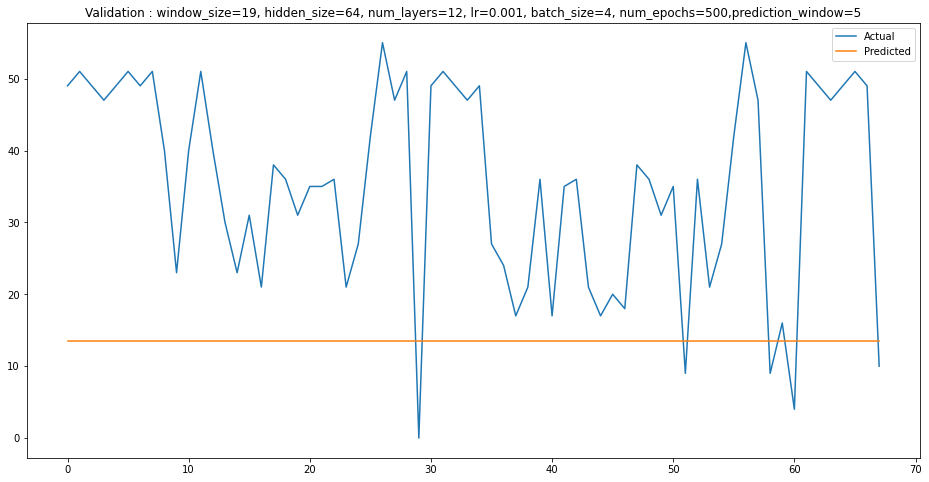

In [40]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_val_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_val_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

y_test_1 = y_test[:, 0]
# y_test_2 = y_test[:, 1]
# y_test_3 = y_test[:, 2]

# #get the first column of the predictions
predictions_1 = predictions[:, 0]

plt.figure(figsize=(16,8))
plt.title(f'Validation : window_size={window_size}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window}')
plt.plot(y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.legend()
plt.show()

In [41]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

Test Loss: 626.6242


In [42]:
#get the first column of the test set
y_test_1 = y_test[:, 0]
# y_test_2 = y_test[:, 1]
# y_test_3 = y_test[:, 2]

# #get the first column of the predictions
predictions_1 = predictions[:, 0]
# predictions_2 = predictions[:, 1]
# predictions_3 = predictions[:, 2]

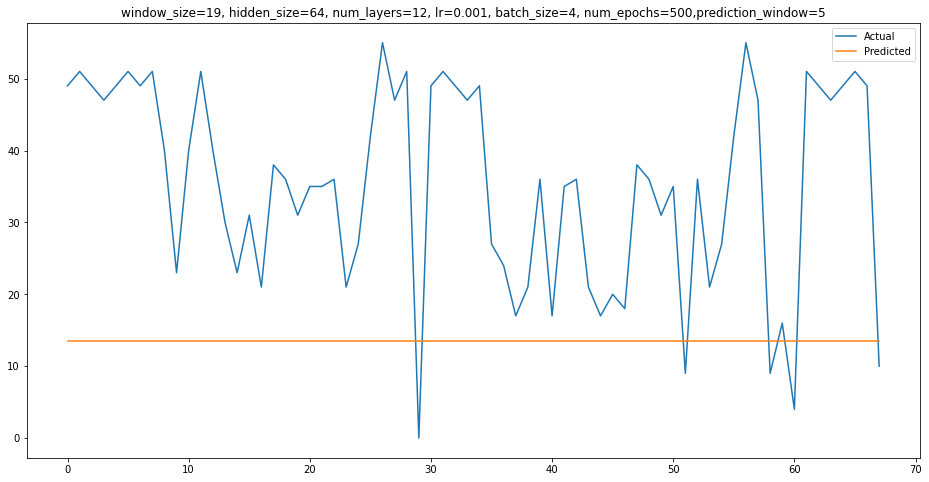

In [43]:
plt.figure(figsize=(16,8))
plt.title(f'window_size={window_size}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window}')
plt.plot(y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.legend()
plt.show()

In [44]:
# MAE, MSE, RMSE losses
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_1, predictions_1)
mse = mean_squared_error(y_test_1, predictions_1)
rmse = np.sqrt(mse)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')
# print the losses in 2 decimal places
print(f'MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')

MAE: 22.76302939302781, MSE: 668.5469719728023, RMSE: 25.856275291944165
MAE: 22.76, MSE: 668.55, RMSE: 25.86
